## Models

This notebook generates models for the Ames Residential properties sample. Later, the best performing models will be used to predict the sale price of the test sample, which will be submitted to Kaggle.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline

Next, I execute the functions that were created in the `02 - Feature Engineering & Functions` notebook, as they are required for the operations in this notebook.

In [2]:
%run clean_data.py

In [2]:
from clean_data import create_infrequent_category

In [ ]:
create_infrequent_category()

My models generate a lot of warnings that are expected. However, the length of those warnings can make it difficult to focus on the analysis. Therefore, I have decided to suppress all warnings.

In [3]:
import warnings
warnings.filterwarnings("ignore")

#### Data import

In [4]:
ames = pd.read_csv('../datasets/train.csv')
ames, cat_label = clean_data(ames, version='mean')
ames = ames[ames['gr_liv_area']<4000]

> Two properties have a living area of more than 4000 sq. ft., and these two properties exert significant influence on the quality and accuracy of the model predictions. Hence, I will exclude them from the training set.

In [5]:
ames.isna().sum().sort_values(ascending=False).head(5)

Id              0
fireplace_qu    0
kitchen_qual    0
electrical      0
central_air     0
dtype: int64

> Sanity check: There is no missing data in the sample. The data has been correctly cleaned.

### Benchmark model

This model is simply the benchmark. simply calculates the average sale price based on the average price in the sample. The goal of this notebook is to improve the mean squared error generated by the subsequent models compared to the benchmark.

In [6]:
X = ames.drop(columns = 'SalePrice')
y = ames['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state=42)

In [7]:
preds = y_train.mean()

In [8]:
rmse = np.sqrt(metrics.mean_squared_error(y_val, preds-y_val+y_val)) #cheap trick to create a vector of predictions with the same size as y_test
rmse

77296.52524199562

> **The benchmark root mean squared error (RMSE) in the validation set is 77297**. The goal is to reduce this error while ensuring that our model does not overfit the data.

In the series of model coming below, I experiment with different combinations of features

#### Model 1: 

In [9]:
X = ames[['overall_qual']]
y = ames['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ohe = OneHotEncoder(sparse_output=False, drop='first', min_frequency=0.01)
X_train_ohe = ohe.fit_transform(X_train)

lr = LinearRegression()
lr.fit(X_train_ohe, y_train)

X_test_ohe = ohe.transform(X_test)

print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_ohe))))
print('Train R2:', np.sqrt(metrics.r2_score(y_train, lr.predict(X_train_ohe))))

print('\n')

print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test_ohe))))
print('Train R2:', np.sqrt(metrics.r2_score(y_test, lr.predict(X_test_ohe))))

Train RMSE: 43100.18725935951
Train R2: 0.8389496989960795


Test RMSE: 41251.60959285026
Train R2: 0.8548885737901902


#### Model 2
In this model, we also include the variable with the second-highest correlation with the SalePrice in the model. but first, I create a code block, that enclude feature transformations.

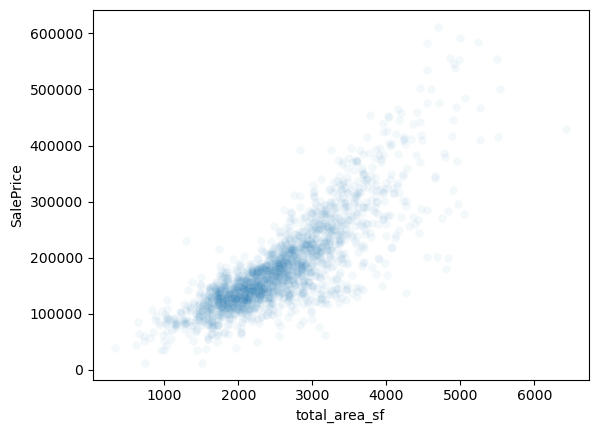

In [10]:
sns.scatterplot(data=ames, x='total_area_sf', y='SalePrice', alpha=.05);

### Column Transformer

The numerical features in the dataset will be standardized, while the categorical variables will be converted into dummy variables. Standard scaling involves transforming the numerical features to have a mean of 0 and a standard deviation of 1.

For the categorical variables, they will be transformed into dummy variables using one-hot encoding. This process creates binary variables for each category of the original categorical feature. This allows the categorical information to be represented in a numerical format.

Additionally, categories with low frequencies will be combined together. By doing so, it ensures that there are sufficient samples for each category and prevents the model from relying too heavily on rare categories that may not be representative of the overall dataset.

By standardizing the numerical features and converting categorical variables into dummy variables, the dataset is prepared for further analysis and modeling, taking into account the different requirements and characteristics of each variable type.

In [11]:
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='infrequent_if_exist')

ss = StandardScaler()

ct = ColumnTransformer(
    [
    ('ohe', ohe, X.select_dtypes(include='object').columns),
    ('ss', ss, X.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough'
    )

In [12]:
X = ames[['overall_qual', 'total_area_sf']]
y = ames['SalePrice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_ct, y_train)


print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_ct))))
print('Train R2:', np.sqrt(metrics.r2_score(y_train, lr.predict(X_train_ct))))

print('\n')

print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test_ct))))
print('Train R2:', np.sqrt(metrics.r2_score(y_test, lr.predict(X_test_ct))))

Train RMSE: 32430.758721053124
Train R2: 0.9123144588797092


Test RMSE: 30690.238137527525
Train R2: 0.9225055587860257


> This significantly reduced the rmse of test set. However, the relationship between price and sq ft of the house seems to be non linear. Next, I include the quadratic form of `gr_liv_area` into the model.

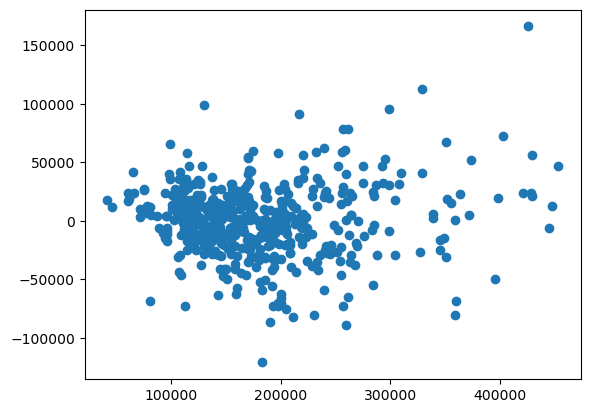

In [13]:
preds = lr.predict(X_test_ct)
resids = y_test - preds
plt.scatter(preds, resids)

> Looking at the residuals plot, it is evident that there is a presence of heteroscedasticity. To mitigate this issue, the next step involves transforming the target variable into a logarithmic form.

#### Model 3

In [14]:
X = ames[['overall_qual', 'total_area_sf']]
y = np.log(ames['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_ct, y_train)

print('Train RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(lr.predict(X_train_ct)))))
print('Train R2:', np.sqrt(metrics.r2_score(y_train, lr.predict(X_train_ct))))

print('\n')

print('Train RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(lr.predict(X_test_ct)))))
print('Train R2:', np.sqrt(metrics.r2_score(y_test, lr.predict(X_test_ct))))

Train RMSE: 31216.874185730103
Train R2: 0.9007286397896596


Train RMSE: 28658.046029824058
Train R2: 0.8980174247373832


> After transforming the SalePrice variable into logarithmic format, there is an improvement in the model's performance in terms of Root Mean Squared Error (RMSE). However, the improvement is not significant.

## Feature Selection

The process of selecting features to manually add into the model can be very time-consuming and inefficient. Instead, in this step, I am developing a function that systematically for selecting the best features for a given predictive modeling task. The function utilizes a forward selection approach to iteratively select the best features. It starts with an empty set of selected features (mif) and continues until all features have been evaluated. In each iteration, the function fits the model using the selected features and computes the test root mean squared error (RMSE) as the evaluation metric. The feature with the lowest test RMSE is added to the selected features (mif), and the corresponding RMSE value is recorded. The process continues until the addition of new features does not improve the model performance.

The function employs one-hot encoding and standard scaling for categorical and numerical features, respectively, using the OneHotEncoder and StandardScaler transformers from scikit-learn. It utilizes the train_test_split function to split the data into training and testing sets. The fitted model is used to make predictions on the test set, and the test RMSE is computed using the appropriate transformation for the target variable (y_var).

The function returns two lists: best_predictors containing the selected features in the order of their selection, and step_rmse containing the corresponding test RMSE values at each step.

Note: The function assumes that the necessary libraries (numpy, pandas, scikit-learn) have been imported and that the required modules and objects (OneHotEncoder, StandardScaler, train_test_split) have been properly defined.

In [15]:
def feature_selector(y_var, X_vars, model, y_log=False, ts=0.25, rs=42):
    
    """
    Selects the best features for a given predictive modeling task.

    Parameters:
        y_var (array-like): The target variable or response variable for the predictive model.
        X_vars (pandas.DataFrame): The input variables or features used for the predictive model.
        model: The machine learning model used for the prediction task.
        y_log (bool, optional): A boolean flag indicating whether to apply a logarithmic transformation to the target variable. Default is False.
        ts (float, optional): The test size for the train-test split when evaluating the model performance. Default is 0.25.
        rs (int, optional): The random state for reproducibility. Default is 42.

    Returns:
        tuple: A tuple containing two lists. The first list contains the selected features in the order of their selection,
               and the second list contains the corresponding test RMSE values at each step.

    """

    step_rmse = []
    mif = [] 
    
    while not X_vars.empty:
        rmse_dict = {}

        if mif:
            col_list = X_vars.drop(columns= mif).columns
        else:
            col_list = X_vars.columns
            
            
        if y_log:
            y = np.log(y_var)
        else:
            y = y_var
            
                
        for col in col_list:
            if mif:
                X = X_vars[f"{col}, {', '.join(mif)}".split(', ')]
            else: 
                X = X_vars[[col]]  

            ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='infrequent_if_exist')

            ss = StandardScaler()

            ct = ColumnTransformer(
                [
                    ('ohe', ohe, X.select_dtypes(include='object').columns),
                    ('ss', ss, X.select_dtypes(include=['float64', 'int64']).columns)
                ],
                remainder='passthrough'
            )

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)
            X_train_ct = ct.fit_transform(X_train)
            X_test_ct = ct.transform(X_test)

            mod = model

            try:
                mod.fit(X_train_ct, y_train)
            except:
                continue

            preds_test = np.exp(mod.predict(X_test_ct))

            if y_log:
                try:
                    preds_test = np.exp(mod.predict(X_test_ct))
                    test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), preds_test))
                except:
                    continue
            else:
                try:
                    preds_test = mod.predict(X_test_ct)
                    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, preds_test))
                except:
                    continue

            rmse_dict[col] = test_rmse
            
                
        rmse_df = pd.DataFrame(rmse_dict, index=['test_rmse']).T
                
        most_imp_feature = rmse_df.sort_values('test_rmse')[:1].index.tolist()

        mif.append(most_imp_feature[0])
        step_rmse.append(rmse_df.sort_values('test_rmse')['test_rmse'][0])

        if len(step_rmse) > 1 and step_rmse[-1] >= step_rmse[-2]:
            break

    best_predictors = mif[:-1]
    return best_predictors, step_rmse[:-1]

### Model 4: Linear regression with best predictors

In [16]:
%%time
best_predictors_lr, rmse_change = feature_selector(y_var=ames['SalePrice'], 
                                                X_vars=ames.drop(columns=['SalePrice', 'Id']), 
                                                model = LinearRegression(), 
                                                y_log=True, 
                                                ts=0.25, 
                                                rs=42
                                               )



X = ames[best_predictors_lr]

y = np.log(ames['SalePrice'])


### Feature preparation
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='infrequent_if_exist')

ss = StandardScaler()

ct = ColumnTransformer(
    [
    ('ohe', ohe, X.select_dtypes(include='object').columns),
    ('ss', ss, X.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough'
    )

####


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_ct, y_train)

print('Train RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(lr.predict(X_train_ct)))))
print('Train R2:', np.sqrt(metrics.r2_score(y_train, lr.predict(X_train_ct))))

print('\n')

print('Test RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(lr.predict(X_test_ct)))))
print('Test R2:', np.sqrt(metrics.r2_score(y_test, lr.predict(X_test_ct))))

print('\n')


Train RMSE: 19715.13051143077
Train R2: 0.9622829946394753


Test RMSE: 16538.58725177302
Test R2: 0.9542260817357977


CPU times: user 3min 57s, sys: 4min 16s, total: 8min 14s
Wall time: 1min 9s


## Model 4: R1 Regularized(LASSO)

In [17]:
%%time

lasso_cv = LassoCV(n_alphas=30, cv=5, max_iter=3000)

best_predictors_lasso, rmse_change = feature_selector(y_var=ames['SalePrice'], 
                                                X_vars=ames.drop(columns=['SalePrice', 'Id']), 
                                                model = lasso_cv, 
                                                y_log=True, 
                                                ts=0.25, 
                                                rs=42
                                               )


X = ames[best_predictors_lasso]

y = np.log(ames['SalePrice'])


### Feature preparation
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='infrequent_if_exist')

ss = StandardScaler()

ct = ColumnTransformer(
    [
    ('ohe', ohe, X.select_dtypes(include='object').columns),
    ('ss', ss, X.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough'
    )

####


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

alphas_range = np.logspace(-2, 2.2, 300)
lasso_cv = LassoCV(n_alphas=300, cv=10, max_iter=5000)
lasso_cv.fit(X_train_ct, y_train)

preds_train = np.exp(lasso_cv.predict(X_train_ct))
preds_test = np.exp(lasso_cv.predict(X_test_ct))


print('Train RMSE: - LASSO:', np.sqrt(metrics.mean_squared_error(np.exp(y_train), preds_train)))

print('\n')

print('Test RMSE: - LASSO', np.sqrt(metrics.mean_squared_error(np.exp(y_test), preds_test)))

print('\n')


Train RMSE: - LASSO: 19908.39587239296


Test RMSE: - LASSO 16666.922454506093


CPU times: user 11min 44s, sys: 13min 50s, total: 25min 35s
Wall time: 3min 43s


## Model 5: R2 Regularized(Ridge)

In [19]:
%%time
r_alphas = np.logspace(-1.5, 2, 40)
 
ridge_cv = RidgeCV(alphas=r_alphas, cv=5)

best_predictors_ridge, rmse_change = feature_selector(y_var=ames['SalePrice'], 
                                                X_vars=ames.drop(columns=['SalePrice', 'Id']), 
                                                model = ridge_cv, 
                                                y_log=True, 
                                                ts=0.25, 
                                                rs=42
                                               )



X = ames[best_predictors_ridge]

y = np.log(ames['SalePrice'])

### Feature preparation
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='infrequent_if_exist')

ss = StandardScaler()

ct = ColumnTransformer(
    [
    ('ohe', ohe, X.select_dtypes(include='object').columns),
    ('ss', ss, X.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough'
    )

####


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

r_alphas = np.logspace(-2, 2.2, 300)
#     # Cross-validate over our list of ridge alphas.
 
ridge_cv = RidgeCV(alphas=r_alphas, cv=10)
ridge_cv.fit(X_train_ct, y_train)


preds_train = np.exp(ridge_cv.predict(X_train_ct))
preds_test = np.exp(ridge_cv.predict(X_test_ct))


print('Train RMSE: Ridge', np.sqrt(metrics.mean_squared_error(np.exp(y_train), preds_train)))

print('\n')

print('Test RMSE: Ridge', np.sqrt(metrics.mean_squared_error(np.exp(y_test), preds_test)))

print('\n')

Train RMSE: Ridge 19698.318358109664


Test RMSE: Ridge 16227.980555893888


CPU times: user 56min 37s, sys: 57min 13s, total: 1h 53min 50s
Wall time: 17min 55s


In [27]:
rmse_change

[41585.588473582124,
 28664.786893793935,
 26351.484535875938,
 24662.08661140844,
 23511.757668311468,
 22300.452865204235,
 20739.545177096104,
 20079.55085404146,
 19648.62742124009,
 19226.92789818712,
 18952.14558239232,
 18713.33465882903,
 18400.155933317834,
 18148.10235744069,
 17943.090389455956,
 17729.6086166429,
 17502.957872953542,
 17364.432269247784,
 17226.434688860387,
 17095.795446254404,
 17004.377687330336,
 16868.460923717445,
 16786.66165538067,
 16707.48386119055,
 16629.311626027054,
 16557.005712703925,
 16500.965824895746,
 16461.060444372728,
 16432.9713903435,
 16390.36941407069,
 16374.193818169597,
 16360.45560014471,
 16347.65682146421,
 16335.516200950706,
 16324.379798840942,
 16313.707578191581,
 16268.822300378888,
 16253.747744941424,
 16243.323739562846,
 16236.626538998951,
 16231.720316891395,
 16228.592974801802]

In [20]:
# https://pythonspot.com/save-a-dictionary-to-a-file/

import pickle

models_best_predictors = {'lr_best_predictors': best_predictors_lr,
    'lasso_best_predictors': best_predictors_lasso,
    'ridge_best_predictors': best_predictors_ridge}


import pickle

# create a binary pickle file 
f = open("../datasets/models_predictor.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(models_best_predictors,f)

# close file
f.close()

## Inferential Analysis

In this section, the focus is on investigating the impact of individual features on determining property prices, specifically emphasizing elements that homeowners can modify to enhance their property value.

In [21]:
ames = pd.read_csv('../datasets/train.csv')
ames, cat_label = clean_data(ames, version='mean')
ames = ames[ames['gr_liv_area']<4000]

ames['total_bath'] = ames['total_bath'] + ames['bsmt_total_bath']

In [22]:
X = ames[['gr_liv_area', 'have_fence', 'garage_area', 'mas_vnr_area', 'central_air', 'age', 'bldg_type', 'wood_deck_sf',
           'age_by_remodel', 'have_fireplaces', 'porch_sf', 'bedroom_abvgr', 
           'total_bsmt_sf', 'lot_area', 'neighborhood', 'kitchen_abvgr', 'total_bath']]


y=ames['SalePrice']

In [23]:
value_counts = X['neighborhood'].value_counts()
low_freq_levels = value_counts[value_counts < 100].index
X['neighborhood'] = np.where(X['neighborhood'].isin(low_freq_levels), 'other', X['neighborhood'])


In [24]:
value_counts = X['bldg_type'].value_counts()
low_freq_levels = value_counts[value_counts < 100].index
X['bldg_type'] = np.where(X['bldg_type'].isin(low_freq_levels), 'other', X['bldg_type'])

In [25]:
X_sm = sm.add_constant(X)
X_sm = pd.get_dummies(columns=X_s
                      m.select_dtypes(include='object').columns, drop_first=True, data=X_sm)
sm.OLS(y, X_sm).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     449.7
Date:                Mon, 05 Jun 2023   Prob (F-statistic):               0.00
Time:                        06:26:49   Log-Likelihood:                -24095.
No. Observations:                2049   AIC:                         4.824e+04
Df Residuals:                    2023   BIC:                         4.839e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.742e+04   6682.255      8.592      0.000    4.43e+04    7.05e+04
gr_liv_area             67.7109      2.629     25.759      0.000      62.556      72.866
garage_area             33.7802      4.456      7.580      0.000      25.041      42.520
mas_vnr_area            41.5977      4.791      8.682      0.000      32.202      50.993
age                   -373.5953     43.825     -8.525      0.000    -459.542    -287.649
wood_deck_sf            17.5194      5.957      2.941      0.003       5.837      29.202
age_by_remodel        -452.8579     46.911     -9.654      0.000    -544.857    -360.859
porch_sf                30.9037      7.284      4.243      0.000      16.619      45.188
bedroom_abvgr        -1.148e+04   1137.120    -10.095      0.000   -1.37e+04   -9249.483
total_bsmt_sf           38.3467      2.105     18.218      0.000      34.219      42.475
lot_area                 0.5804      0.117      4.957      0.000       0.351       0.810
kitchen_abvgr        -1.223e+04   4437.025     -2.756      0.006   -2.09e+04   -3526.198
total_bath            7526.3019   1283.860      5.862      0.000    5008.475       1e+04
have_fence_Yes       -1887.5955   1855.411     -1.017      0.309   -5526.310    1751.119
central_air_Y        -2909.2131   3100.794     -0.938      0.348   -8990.295    3171.869
bldg_type_TwnhsE     -1.657e+04   2980.910     -5.558      0.000   -2.24e+04   -1.07e+04
bldg_type_other      -1.922e+04   3220.838     -5.968      0.000   -2.55e+04   -1.29e+04
have_fireplaces_Yes   6862.4069   1704.079      4.027      0.000    3520.474    1.02e+04
neighborhood_Edwards  4373.2169   3879.359      1.127      0.260   -3234.739     1.2e+04
neighborhood_Gilbert -4673.2585   3882.137     -1.204      0.229   -1.23e+04    2940.145
neighborhood_NAmes    4227.6186   3347.134      1.263      0.207   -2336.571    1.08e+04
neighborhood_NridgHt  4.406e+04   3991.383     11.038      0.000    3.62e+04    5.19e+04
neighborhood_OldTown  1121.8225   4263.329      0.263      0.792   -7239.151    9482.795
neighborhood_Sawyer   4058.4802   4036.702      1.005      0.315   -3858.047     1.2e+04
neighborhood_Somerst  1.155e+04   3704.919      3.117      0.002    4283.294    1.88e+04
neighborhood_other    8669.3320   2878.428      3.012      0.003    3024.340    1.43e+04
==============================================================================
Omnibus:                      484.052   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3787.044
Skew:                           0.892   Prob(JB):                         0.00
Kurtosis:                       9.417   Cond. No.                     1.48e+05
==============================================================================

Notes:
[1] Standard Errors 